# Party Cartograms with Non-Global Density Scaling

This notebook demonstrates how to create **party-specific cartograms** for German federal election results (Bundestagswahl 2021), where each party's cartogram uses its own density scaling.

## Key Difference: Non-Global vs Global Scaling

- **Global scaling** (previous notebook): All party cartograms use the same boundary density value, making them directly comparable in terms of absolute vote shares.
- **Non-global scaling** (this notebook): Each party's cartogram is scaled to its own vote distribution using `set_boundary_to='40percent_mean'`. This emphasizes **relative regional strength** within each party's voter base.

This approach is useful when you want to highlight where each party performs best *relative to itself*, rather than comparing absolute vote counts across parties.

## Imports

In [1]:
from pathlib import Path

import numpy as np
import geopandas as gpd
import polars as pl
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from shapely.geometry import Polygon, MultiPolygon
from tqdm import tqdm
from easing_functions import QuadEaseInOut

from pycartogram.geopandas_cartogram import GeoDataFrameWardCartogram
from pycartogram.tools import fix_geodataframe_geometries

%matplotlib inline

## 1. Loading the Data

We load the election statistics from the 2021 Bundestagswahl and the electoral district boundaries.

In [2]:
# Load election statistics
statsdata = pl.read_csv('data/btw21_stats.csv')
statsdata = statsdata.sort(by='wkr_nr')

# Load electoral district geometries
gdf = gpd.read_file("data/Geometrie_Wahlkreise_20DBT_VG250.json")
gdf = gdf.set_crs('EPSG:25832', allow_override=True)

print(f"Loaded {len(gdf)} electoral districts")
print(f"CRS: {gdf.crs}")

Loaded 299 electoral districts
CRS: EPSG:25832


/Users/bfmaier/Dropbox/Archive/additional_datasets/german_geo_data/wahlkreise_cartograms/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/raw.py:200: RuntimeWarning: driver GeoJSON does not support open option CRS
  return ogr_read(


## 2. Setting Up Party Colors

Each party has a distinct color. We create colormaps that transition from white (low vote share) to the party color (high vote share).

In [3]:
# Party definitions and colors
PARTIES = ["CDU", "CSU", "SPD", "GRÜNE", "FDP", "DIE LINKE", "AfD"]
PARTY_COLORS = {
    "CDU": "#737373",
    "CSU": "#858590",
    "SPD": "#fb6a4a",
    "GRÜNE": "#74c476",
    "FDP": "#fe9929",
    "DIE LINKE": "#f768a1",
    "AfD": "#4eb3d3",
}


def hex_to_rgb(hex_color):
    """Convert hex color to RGB tuple (0-1 range)."""
    hex_color = hex_color.lstrip("#")
    return tuple(int(hex_color[i : i + 2], 16) / 255 for i in (0, 2, 4))


def rgb_to_hex(rgb):
    """Convert RGB tuple (0-1 range) to hex color."""
    return "#{:02x}{:02x}{:02x}".format(
        int(rgb[0] * 255), int(rgb[1] * 255), int(rgb[2] * 255)
    )


def create_party_colormap(party):
    """Create a colormap from white to party color."""
    party_rgb = hex_to_rgb(PARTY_COLORS[party])
    colors = [(1.0, 1.0, 1.0), party_rgb]
    return LinearSegmentedColormap.from_list(party, colors, N=256)


def interpolate_colors(color1, color2, t):
    """Interpolate between two hex colors."""
    rgb1 = hex_to_rgb(color1)
    rgb2 = hex_to_rgb(color2)
    rgb = tuple((1 - t) * c1 + t * c2 for c1, c2 in zip(rgb1, rgb2))
    return rgb_to_hex(rgb)


# Create colormaps for each party
cmaps = {party: create_party_colormap(party) for party in PARTIES}

## 3. Preparing the GeoDataFrame

For each party, we calculate:
- **Density**: Vote percentage divided by geographic area (used for cartogram distortion)
- **Normalized values**: Vote shares scaled to [0, 1] for color mapping
- **Colors**: Each district gets a color based on its normalized vote share

We also create **color interpolators** for smooth transitions between party visualizations in animations.

In [4]:
# Handle missing values (CSU only runs in Bavaria)
min_val = 0.5
new_statsdata = statsdata.clone()
for party in PARTIES:
    col_name = f"{party}_zweitstimme"
    if col_name in new_statsdata.columns:
        new_statsdata = new_statsdata.with_columns(
            pl.col(col_name).cast(pl.Float64).fill_null(min_val)
        )
new_statsdata_pd = new_statsdata.to_pandas()

In [5]:
# Calculate area and party-specific metrics
areas = [shape.area for shape in gdf['geometry']]
gdf['area'] = areas

for party in PARTIES:
    col_name = f"{party}_zweitstimme"
    if col_name in new_statsdata_pd.columns:
        # Density for cartogram distortion
        gdf[f"{party}_density"] = new_statsdata_pd[col_name] / gdf['area']
        
        # Raw vote share
        gdf[f"{party}_zweitstimme"] = new_statsdata_pd[col_name]
        
        # Normalized values [0, 1] for color mapping
        val = gdf[f"{party}_zweitstimme"]
        normalized = (val - val.min()) / (val.max() - val.min())
        gdf[f"{party}_zweitstimme_normalized"] = normalized
        
        # Assign colors based on normalized values
        gdf[f"{party}_zweitstimme_color"] = [
            rgb_to_hex(cmaps[party](v)[:3]) for v in normalized
        ]

print(f"Prepared density columns for {len(PARTIES)} parties")

Prepared density columns for 7 parties


In [6]:
# Create color interpolators for animation transitions between parties
color_interpolators = {
    party_src: {
        party_trg: [
            lambda t, c1=c1, c2=c2: interpolate_colors(c1, c2, t)
            for c1, c2 in zip(
                gdf[f"{party_src}_zweitstimme_color"],
                gdf[f"{party_trg}_zweitstimme_color"]
            )
        ]
        for party_trg in PARTIES
    }
    for party_src in PARTIES
}

## 4. Defining the Plotting Function

This function handles visualization with support for:
- Party-colored districts based on vote share
- State (Bundesland) boundaries
- Island boundary handling (for districts with multiple polygons)
- Color interpolation for animated transitions between parties

In [7]:
def plot_gdf(
    gdf,
    party,
    target_party=None,
    interpolation_t=None,
    linewidth_wkr=0.3,
    linewidth_state=1.5,
    figsize=(10, 10),
    edgecolor='#333333',
    show_title=True,
    ax=None,
):
    """
    Plot a GeoDataFrame with party colors and state boundaries.
    
    Parameters
    ----------
    gdf : GeoDataFrame
        The geodataframe to plot (original or cartogram-transformed)
    party : str
        The source party for coloring
    target_party : str, optional
        Target party for color interpolation during transitions
    interpolation_t : float, optional
        Interpolation parameter [0, 1] for color transitions
    linewidth_wkr : float
        Line width for electoral district boundaries
    linewidth_state : float
        Line width for state boundaries
    figsize : tuple
        Figure size
    edgecolor : str
        Edge color for boundaries
    show_title : bool
        Whether to show party name as title
    ax : matplotlib Axes, optional
        Existing axes to plot on (for video recording)
    
    Returns
    -------
    ax : matplotlib Axes
    """
    t = interpolation_t
    color_col = f"{party}_zweitstimme_color"
    
    # Handle color interpolation for transitions
    if t is not None and target_party is not None:
        target_color_col = f"{target_party}_zweitstimme_color"
        # Fade title based on transition progress
        if t < 0.5:
            title_alpha = (0.5 - t) / 0.5
            title_str = party
        else:
            title_alpha = (t - 0.5) / 0.5
            title_str = target_party
        
        # Interpolate colors between parties
        colors = [
            interp(float(t))
            for interp in color_interpolators[party][target_party]
        ]
    else:
        title_alpha = 1
        title_str = party
        colors = gdf[color_col].tolist()
    
    # Clear existing axes if provided, otherwise create new figure
    if ax is not None:
        ax.clear()
        fig = ax.get_figure()
    else:
        fig, ax = plt.subplots(figsize=figsize)
    
    fig.set_facecolor('#f8f8f8')
    
    # Plot electoral districts
    gdf.plot(
        ax=ax,
        color=colors,
        edgecolor=edgecolor,
        linewidth=linewidth_wkr,
    )
    
    # Draw state boundaries
    gdf_valid = fix_geodataframe_geometries(gdf)
    laender = gdf_valid.dissolve(by='LAND_NR').buffer(10)
    laender = laender.apply(
        lambda shape: Polygon(shape.exterior.coords)
        if isinstance(shape, Polygon)
        else max(shape.geoms, key=lambda a: a.area)
    )
    laender.plot(facecolor='None', edgecolor=edgecolor, ax=ax, lw=linewidth_state)
    
    # Draw island boundaries (for MultiPolygon districts)
    for island, polyid in zip([8, 15], [1, 1]):
        if island < len(gdf):
            multi = gdf['geometry'].iloc[island]
            if isinstance(multi, MultiPolygon):
                geoms = list(multi.geoms)
                if len(geoms) > polyid:
                    p = gpd.GeoSeries(geoms[polyid])
                    p.plot(facecolor='None', edgecolor=edgecolor, ax=ax, lw=linewidth_state)
    
    ax.axis('off')
    
    if show_title:
        fig.suptitle(
            title_str,
            color='#555555',
            fontsize=24,
            x=0.03,
            y=0.97,
            ha='left',
            va='top',
            alpha=title_alpha
        )
    
    # Set fixed axis limits for consistent framing
    xlim = (254554.69491311393, 953002.5016813722)
    ylim = (5198910.185803056, 6126105.330140842)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    fig.tight_layout()
    
    return ax

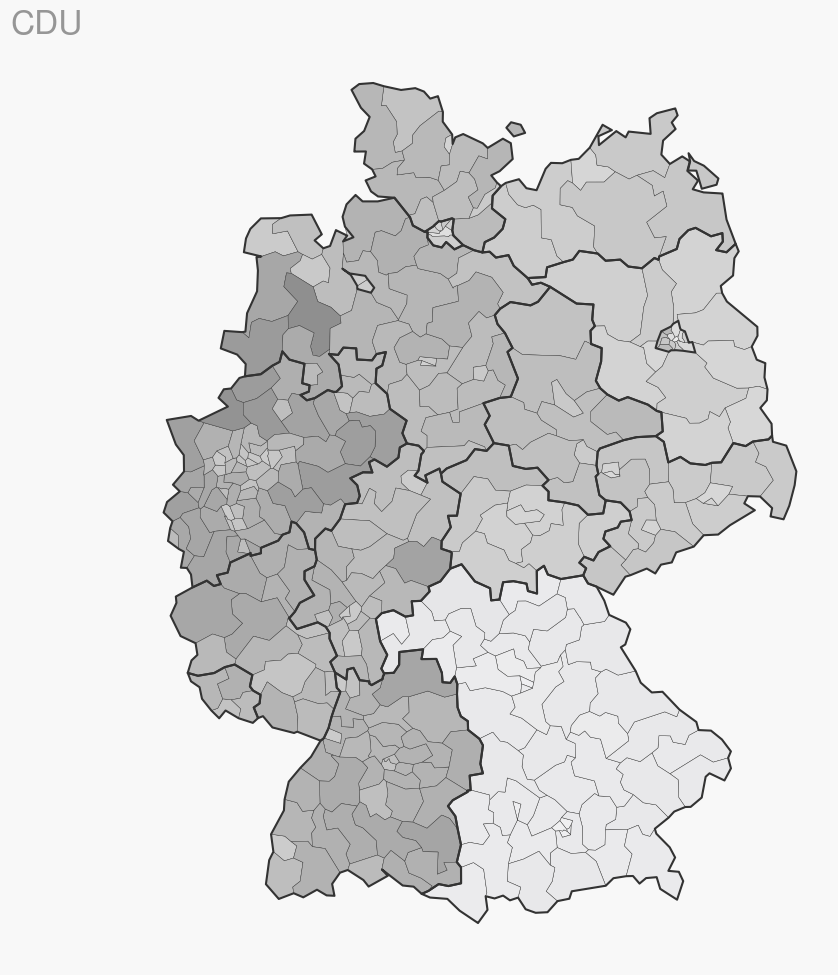

In [8]:
# Test the plotting function with color interpolation
ax = plot_gdf(gdf, 'CDU', target_party='CSU', interpolation_t=0.2)

## 5. Creating the Cartograms (Non-Global Scaling)

This is where the **key difference** from global scaling comes in. We use `set_boundary_to='40percent_mean'`, which means:
- The boundary density is set to 40% of the mean density for **each party individually**
- Each party's cartogram maximizes the distortion based on its own vote distribution
- Districts where a party is strong will expand more relative to that party's overall performance

In [9]:
def create_party_cartogram(gdf, party):
    """
    Create a cartogram for a specific party using non-global density scaling.
    
    The key parameter is `set_boundary_to='40percent_mean'`, which scales each
    party's cartogram independently based on its own vote distribution.
    """
    density_col = f"{party}_density"
    if density_col not in gdf.columns:
        print(f"Warning: {density_col} not found")
        return None
    
    carto = GeoDataFrameWardCartogram(
        gdf,
        density_col,
        y_raster_size=2048,
        x_raster_size=768 * 2,
        map_orientation='portrait',
    )
    
    # NON-GLOBAL SCALING: Each party uses its own mean as reference
    carto.cast_density_to_matrix(verbose=True, set_boundary_to='40percent_mean')
    carto.compute(verbose=True)
    
    return carto

In [10]:
# Create cartograms for all parties
cartograms = {}
for party in PARTIES:
    print(f"\n=== Processing {party} ===")
    cartograms[party] = create_party_cartogram(gdf, party)


=== Processing CDU ===


cast density to matrix: 100%|████████████████████████████████████████████████████████████████| 304/304 [00:08<00:00, 33.79it/s]
   88%  |===========================================       |


computing cartogram...


  100%  |==================================================|
transforming wards: 100%|████████████████████████████████████████████████████████████████████| 304/304 [01:03<00:00,  4.80it/s]
/Users/bfmaier/Dropbox/independent-python-packages/pycartogram/pycartogram/ward_cartogram.py:729: UserWarning: Cartogram produced 3 invalid (self-intersecting) polygon(s) at indices: [118, 247, 256]. This typically occurs when there aren't enough vertices to represent the deformation. Consider enriching the original geometries with more points. To fix invalid geometries before operations like dissolve(), use pycartogram.tools.fix_invalid_geometry() for single polygons or pycartogram.tools.fix_geodataframe_geometries() for GeoDataFrames.
  warnings.warn(



=== Processing CSU ===


cast density to matrix: 100%|████████████████████████████████████████████████████████████████| 304/304 [00:09<00:00, 33.09it/s]
   54%  |==========================                        |


computing cartogram...


  100%  |==================================================|                                           | 0/304 [00:00<?, ?it/s]============       |
transforming wards: 100%|████████████████████████████████████████████████████████████████████| 304/304 [01:08<00:00,  4.46it/s]
/Users/bfmaier/Dropbox/independent-python-packages/pycartogram/pycartogram/ward_cartogram.py:729: UserWarning: Cartogram produced 3 invalid (self-intersecting) polygon(s) at indices: [118, 247, 256]. This typically occurs when there aren't enough vertices to represent the deformation. Consider enriching the original geometries with more points. To fix invalid geometries before operations like dissolve(), use pycartogram.tools.fix_invalid_geometry() for single polygons or pycartogram.tools.fix_geodataframe_geometries() for GeoDataFrames.
  warnings.warn(



=== Processing SPD ===


cast density to matrix: 100%|████████████████████████████████████████████████████████████████| 304/304 [00:09<00:00, 33.21it/s]
   57%  |============================                      |


computing cartogram...


  100%  |==================================================|
transforming wards: 100%|████████████████████████████████████████████████████████████████████| 304/304 [01:08<00:00,  4.44it/s]
/Users/bfmaier/Dropbox/independent-python-packages/pycartogram/pycartogram/ward_cartogram.py:729: UserWarning: Cartogram produced 3 invalid (self-intersecting) polygon(s) at indices: [118, 247, 256]. This typically occurs when there aren't enough vertices to represent the deformation. Consider enriching the original geometries with more points. To fix invalid geometries before operations like dissolve(), use pycartogram.tools.fix_invalid_geometry() for single polygons or pycartogram.tools.fix_geodataframe_geometries() for GeoDataFrames.
  warnings.warn(



=== Processing GRÜNE ===


cast density to matrix: 100%|████████████████████████████████████████████████████████████████| 304/304 [00:09<00:00, 33.28it/s]
   42%  |=====================                             |


computing cartogram...


  100%  |==================================================|
transforming wards: 100%|████████████████████████████████████████████████████████████████████| 304/304 [01:08<00:00,  4.45it/s]
/Users/bfmaier/Dropbox/independent-python-packages/pycartogram/pycartogram/ward_cartogram.py:729: UserWarning: Cartogram produced 5 invalid (self-intersecting) polygon(s) at indices: [82, 83, 118, 247, 256]. This typically occurs when there aren't enough vertices to represent the deformation. Consider enriching the original geometries with more points. To fix invalid geometries before operations like dissolve(), use pycartogram.tools.fix_invalid_geometry() for single polygons or pycartogram.tools.fix_geodataframe_geometries() for GeoDataFrames.
  warnings.warn(



=== Processing FDP ===


cast density to matrix: 100%|████████████████████████████████████████████████████████████████| 304/304 [00:09<00:00, 33.45it/s]
  100%  |==================================================|



computing cartogram...


transforming wards: 100%|████████████████████████████████████████████████████████████████████| 304/304 [01:08<00:00,  4.46it/s]
/Users/bfmaier/Dropbox/independent-python-packages/pycartogram/pycartogram/ward_cartogram.py:729: UserWarning: Cartogram produced 4 invalid (self-intersecting) polygon(s) at indices: [82, 118, 247, 256]. This typically occurs when there aren't enough vertices to represent the deformation. Consider enriching the original geometries with more points. To fix invalid geometries before operations like dissolve(), use pycartogram.tools.fix_invalid_geometry() for single polygons or pycartogram.tools.fix_geodataframe_geometries() for GeoDataFrames.
  warnings.warn(



=== Processing DIE LINKE ===


cast density to matrix: 100%|████████████████████████████████████████████████████████████████| 304/304 [00:09<00:00, 33.16it/s]
    2%  |=                     


computing cartogram...


  100%  |==================================================|
transforming wards: 100%|████████████████████████████████████████████████████████████████████| 304/304 [01:07<00:00,  4.50it/s]
/Users/bfmaier/Dropbox/independent-python-packages/pycartogram/pycartogram/ward_cartogram.py:729: UserWarning: Cartogram produced 3 invalid (self-intersecting) polygon(s) at indices: [118, 247, 256]. This typically occurs when there aren't enough vertices to represent the deformation. Consider enriching the original geometries with more points. To fix invalid geometries before operations like dissolve(), use pycartogram.tools.fix_invalid_geometry() for single polygons or pycartogram.tools.fix_geodataframe_geometries() for GeoDataFrames.
  warnings.warn(



=== Processing AfD ===


cast density to matrix: 100%|████████████████████████████████████████████████████████████████| 304/304 [00:09<00:00, 33.40it/s]
    2%  |=                       


computing cartogram...


  100%  |==================================================|
transforming wards: 100%|████████████████████████████████████████████████████████████████████| 304/304 [01:08<00:00,  4.46it/s]
/Users/bfmaier/Dropbox/independent-python-packages/pycartogram/pycartogram/ward_cartogram.py:729: UserWarning: Cartogram produced 2 invalid (self-intersecting) polygon(s) at indices: [247, 256]. This typically occurs when there aren't enough vertices to represent the deformation. Consider enriching the original geometries with more points. To fix invalid geometries before operations like dissolve(), use pycartogram.tools.fix_invalid_geometry() for single polygons or pycartogram.tools.fix_geodataframe_geometries() for GeoDataFrames.
  warnings.warn(


## 6. Visualizing the Results

Each party's cartogram shows where that party performs best relative to its own average. Compare this to global scaling where all parties share the same reference point.

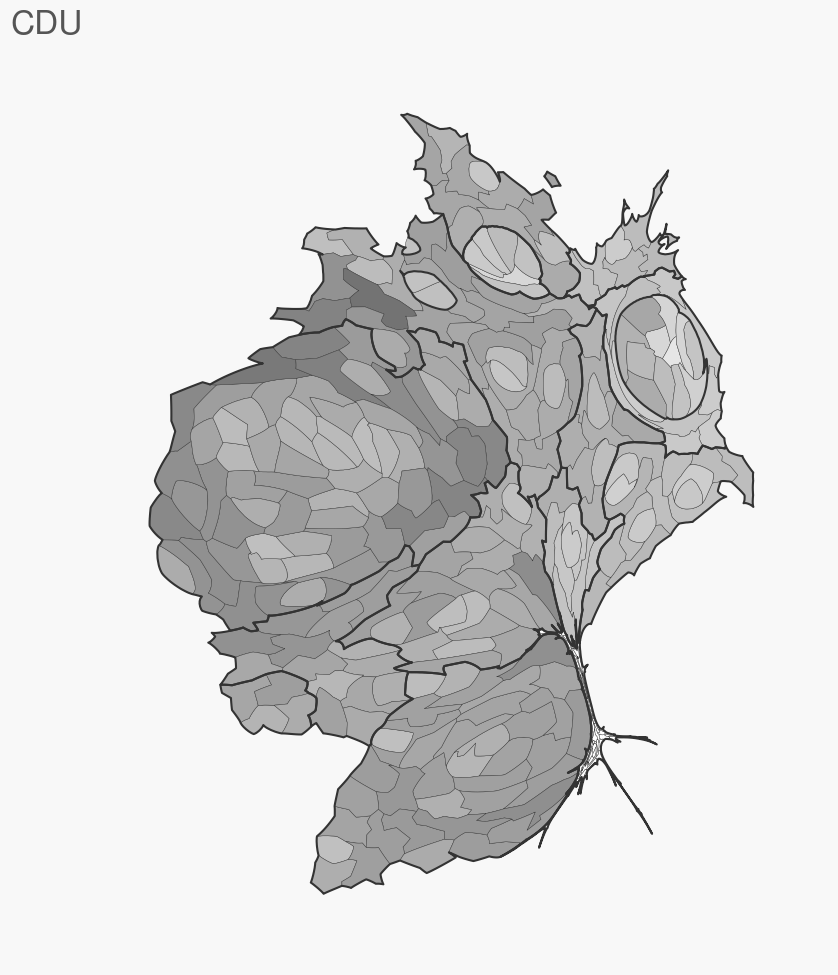

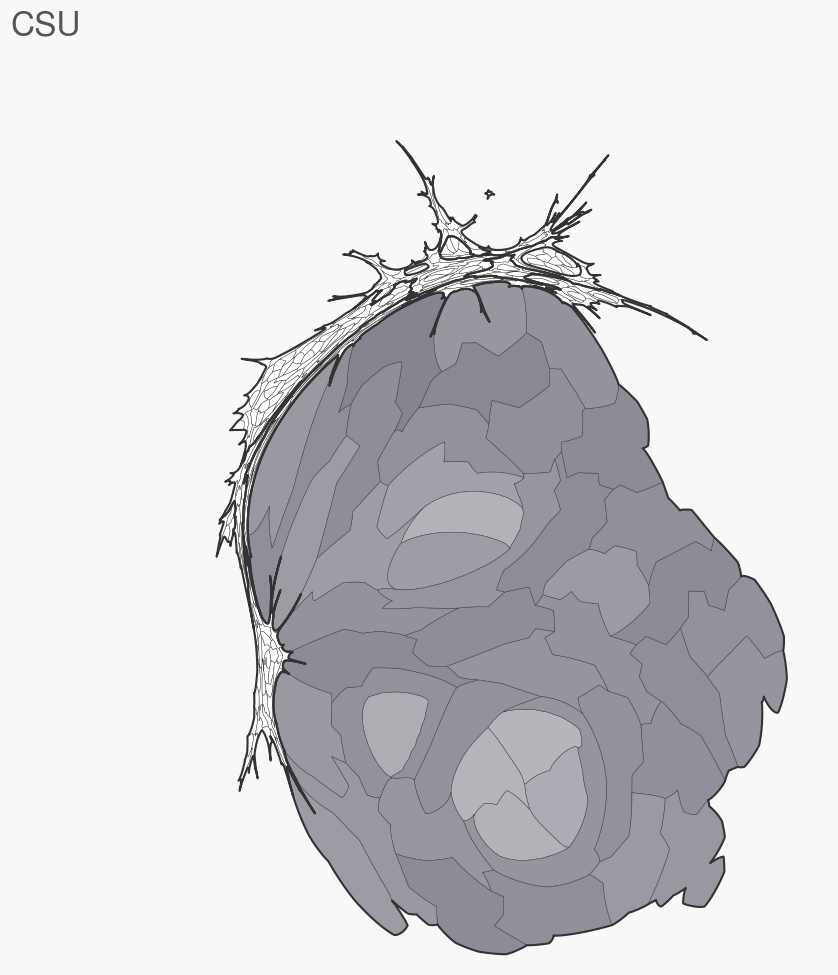

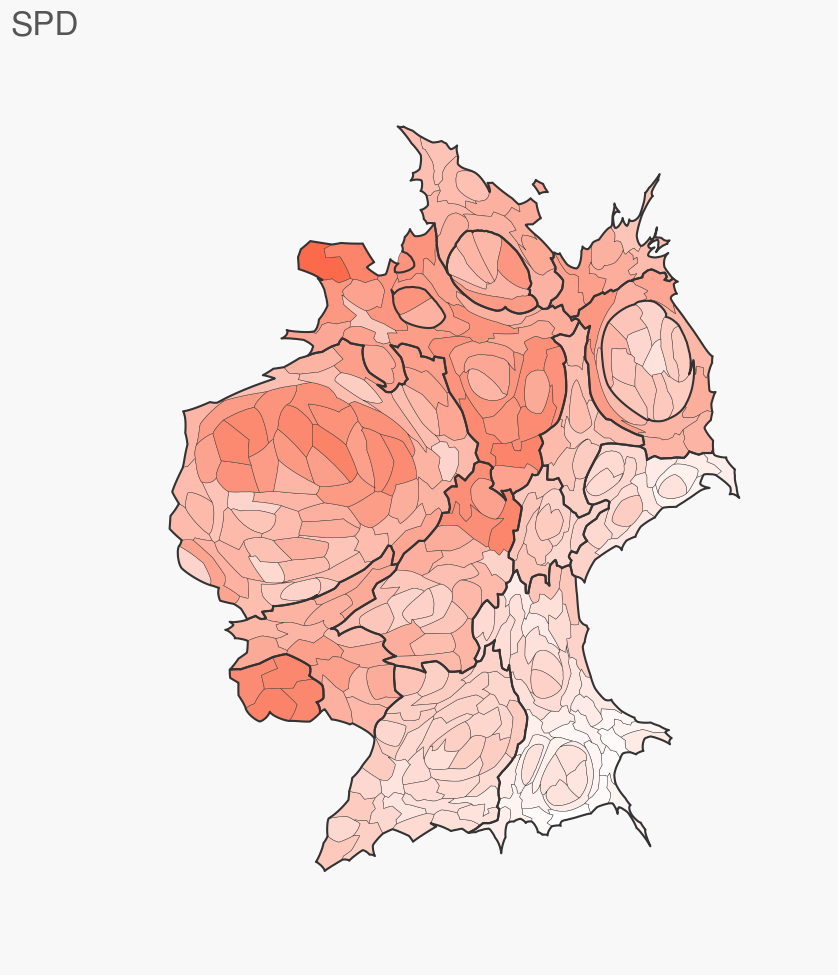

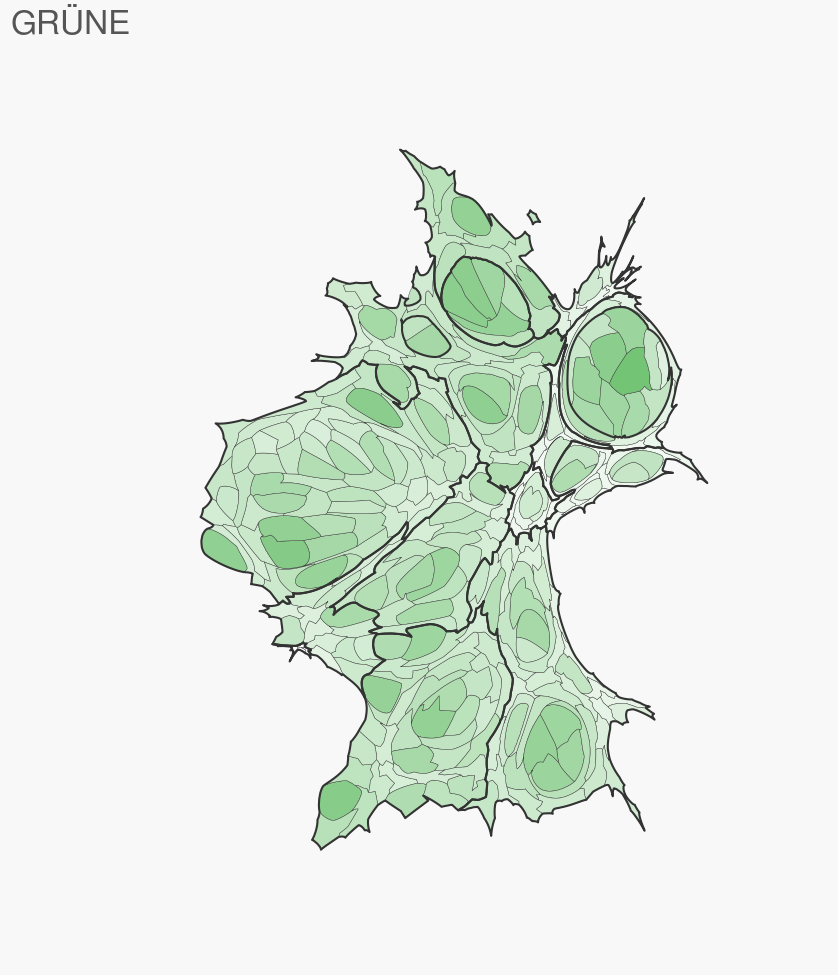

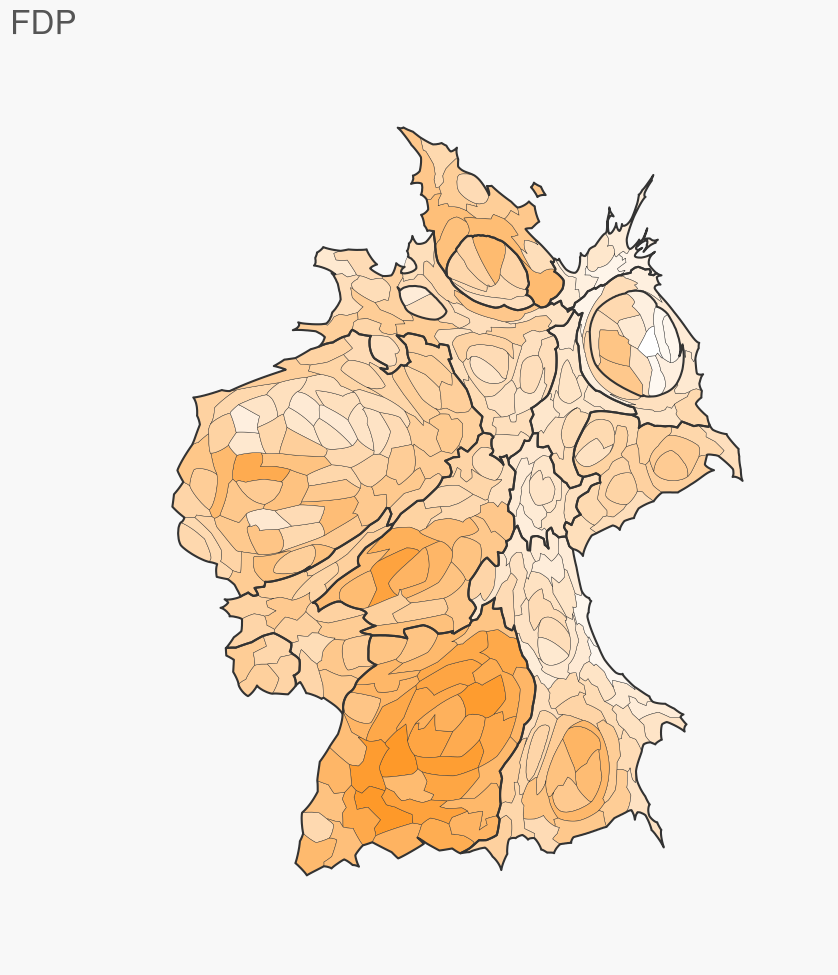

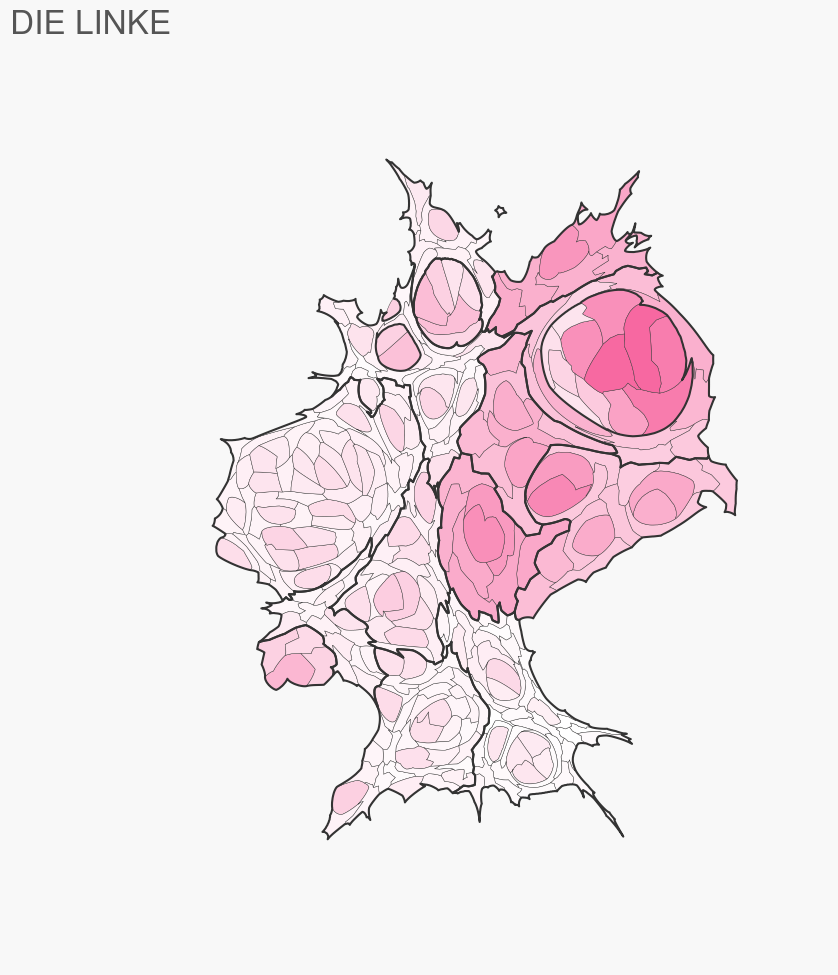

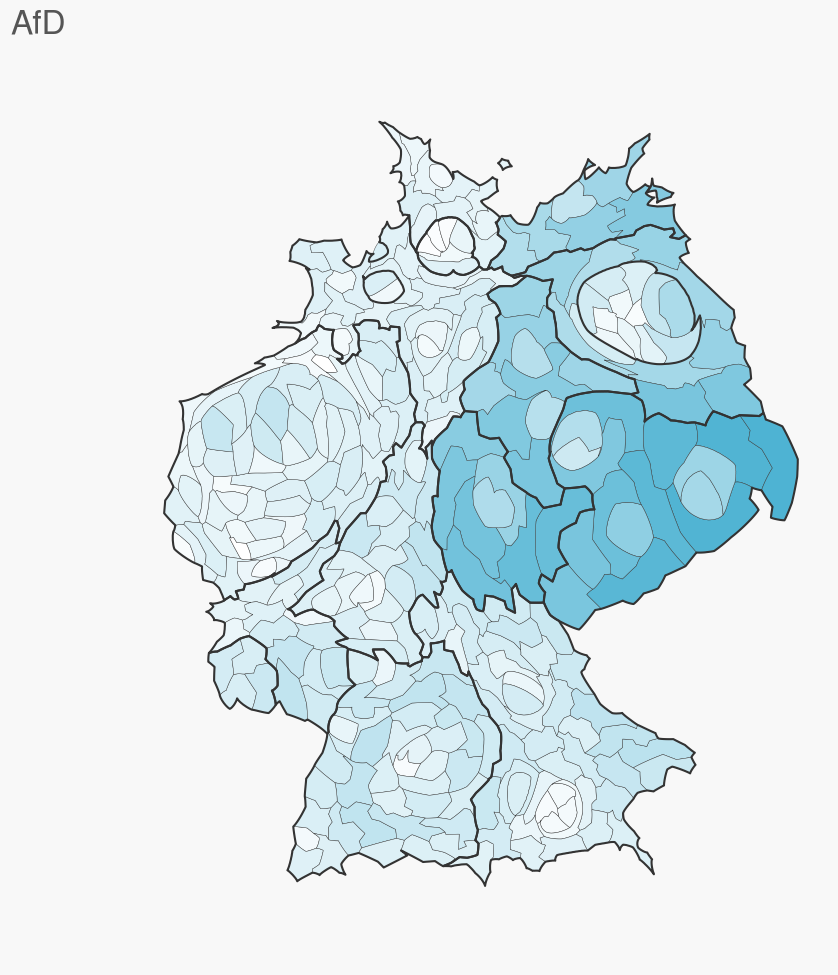

In [11]:
# Plot all party cartograms
for party in PARTIES:
    if cartograms[party] is not None:
        gdf_carto = cartograms[party].get_cartogram_geo_df()
        plot_gdf(gdf_carto, party)

## 7. Creating Animated Video

Instead of saving individual PNG frames, we write directly to an MP4 video file using FFmpeg. This is more efficient and produces a ready-to-use video.

The animation cycles through all parties, showing:
1. Original map → Cartogram (morph)
2. Hold on cartogram  
3. Cartogram → Original map while transitioning colors to next party
4. Brief hold, then repeat

In [14]:
# Animation configuration
from matplotlib.animation import FFMpegWriter

ease = QuadEaseInOut()
fps = 60
dpi = 150

# Animation phases for each party
phases = [
    ('stay_orig', np.zeros(int(fps * 0.1))),      # Brief hold at original
    ('to_carto', np.linspace(0, 1, fps * 1)),     # Morph to cartogram
    ('stay_carto', np.ones(fps * 1)),             # Hold at cartogram
    ('to_next_party_orig', np.linspace(1, 0, fps * 1)),  # Morph back + color transition
]

# Output path
output_dir = Path('animation')
output_dir.mkdir(parents=True, exist_ok=True)
output_file = output_dir / 'zweitstimme_parties_nonglobal_scaling.mp4'

# Set up the video writer
writer = FFMpegWriter(fps=fps, metadata={'title': 'Party Cartograms (Non-Global Scaling)'})

print(f"Will write video to: {output_file}")

Will write video to: animation/zweitstimme_parties_nonglobal_scaling.mp4


In [15]:
# Create the animation video
src_parties = PARTIES
trg_parties = PARTIES[1:] + [PARTIES[0]]  # Circular transition

# Create a single figure to reuse throughout the animation
fig, ax = plt.subplots(figsize=(10, 10))

with writer.saving(fig, output_file, dpi=dpi):
    for iparty, (src, trg) in enumerate(zip(src_parties, trg_parties)):
        if cartograms[src] is None:
            continue
        
        src_carto = cartograms[src]
        
        for phase, t_values in phases:
            print(f"{src} - {phase}")
            for __t in tqdm(t_values):
                _t = ease(__t)  # Apply easing
                
                # Generate interpolated frame
                interp = src_carto.get_interpolated_geo_df(_t, ease=None)
                
                if phase == 'to_next_party_orig':
                    # Transitioning back to original + changing colors
                    plot_gdf(interp, src, target_party=trg, interpolation_t=1 - _t, ax=ax)
                else:
                    plot_gdf(interp, src, ax=ax)
                
                # Write frame to video
                writer.grab_frame()

plt.close(fig)
print(f"\nVideo saved to: {output_file}")

CDU - stay_orig


100%|████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:08<00:00,  1.43s/it]


CDU - to_carto


100%|██████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:18<00:00,  3.29it/s]


CDU - stay_carto


100%|██████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:16<00:00,  3.59it/s]


CDU - to_next_party_orig


100%|██████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:19<00:00,  3.12it/s]


CSU - stay_orig


100%|████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.72it/s]


CSU - to_carto


100%|██████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:17<00:00,  3.42it/s]


CSU - stay_carto


100%|██████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:15<00:00,  3.75it/s]


CSU - to_next_party_orig


100%|██████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:18<00:00,  3.20it/s]


SPD - stay_orig


100%|████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.53it/s]


SPD - to_carto


100%|██████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:18<00:00,  3.25it/s]


SPD - stay_carto


100%|██████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:15<00:00,  3.80it/s]


SPD - to_next_party_orig


100%|██████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:19<00:00,  3.12it/s]


GRÜNE - stay_orig


100%|████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.64it/s]


GRÜNE - to_carto


100%|██████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:18<00:00,  3.24it/s]


GRÜNE - stay_carto


100%|██████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:15<00:00,  3.79it/s]


GRÜNE - to_next_party_orig


100%|██████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:18<00:00,  3.24it/s]


FDP - stay_orig


100%|████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.73it/s]


FDP - to_carto


100%|██████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:18<00:00,  3.17it/s]


FDP - stay_carto


100%|██████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:14<00:00,  4.10it/s]


FDP - to_next_party_orig


100%|██████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:16<00:00,  3.63it/s]


DIE LINKE - stay_orig


100%|████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.73it/s]


DIE LINKE - to_carto


100%|██████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:17<00:00,  3.43it/s]


DIE LINKE - stay_carto


100%|██████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:15<00:00,  3.86it/s]


DIE LINKE - to_next_party_orig


100%|██████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:17<00:00,  3.34it/s]


AfD - stay_orig


100%|████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.64it/s]


AfD - to_carto


100%|██████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:16<00:00,  3.55it/s]


AfD - stay_carto


100%|██████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:14<00:00,  4.27it/s]


AfD - to_next_party_orig


100%|██████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:16<00:00,  3.61it/s]


Video saved to: animation/zweitstimme_parties_nonglobal_scaling.mp4


## Summary

This notebook demonstrated **non-global density scaling** for party cartograms:

### Key Concepts

1. **Non-global scaling** (`set_boundary_to='40percent_mean'`): Each party's cartogram is scaled relative to its own vote distribution, maximizing the visual contrast for that party's regional strengths.

2. **Comparison with global scaling**: 
   - Global scaling uses a fixed reference density for all parties → comparable absolute sizes
   - Non-global scaling uses party-specific references → emphasizes relative performance

3. **Color interpolation**: Smooth transitions between party colors during animations using linear RGB interpolation.

4. **Easing functions**: `QuadEaseInOut` provides natural-looking acceleration/deceleration for cartogram morphing.

### When to Use Non-Global Scaling

- When you want to highlight **where each party is strongest relative to itself**
- When the focus is on **intra-party** geographic patterns rather than **inter-party** comparisons
- For storytelling that examines each party's "heartlands" separately

### When to Use Global Scaling

- When comparing **absolute vote shares** across parties
- When the visual size of districts should reflect **real vote counts**
- For fair side-by-side party comparisons